# General trace loader
Interface for loading various traces. Tasks include:
- Resolving class imbalance (TODO)
- Noise reduction (TODO)
- Switching between variants of fixed key / random key traces (TODO)

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from src.tools.cache import cache_np, get_cache
from src.tools.poi import select_poi
from src.tools.traceloader import ASCAD, TraceGroup, TraceCategory

sns.set_style("whitegrid")

In [2]:
ascad = ASCAD()
ascad.default.profile.traces.shape

(200000, 1400)

In [3]:
ascad.default.profile.filter_traces(1).shape

(768, 1400)

<AxesSubplot:>

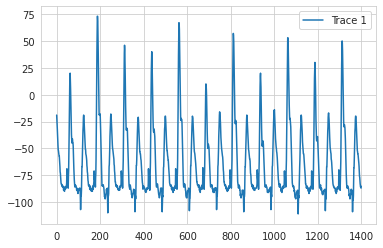

In [4]:
T1 = ascad.default.profile.traces[0]
sns.lineplot(data=pd.DataFrame(T1, columns=["Trace 1"]))

### A closer look at the traces

ASCAD says on its website that the traces in the ASCAD random-keys database is not aligned.
This may be true for the raw traces, but the `ASCAD.h5` file (zooming in on the interesting part from the raw traces)
is clearly aligned:


[(30.0, 100.0),
 Text(0.5, 1.0, 'Small portion of two traces at the beginning.')]

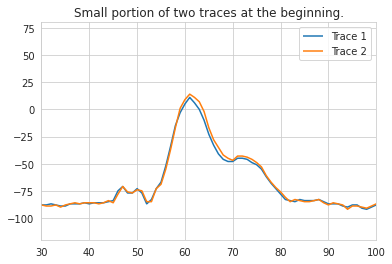

In [5]:
TRACE_PLOT = {
    "dashes": [(1, 0)] * 2,
    "data": pd.DataFrame({
        "Trace 1": ascad.default.profile.traces[1],
        "Trace 2": ascad.default.profile.traces[2]
    })
}

sns.lineplot(**TRACE_PLOT).set(xlim=(30,100),
                               title="Small portion of two traces at the beginning.")

[(1280.0, 1350.0), Text(0.5, 1.0, 'Small portion of two traces at the end.')]

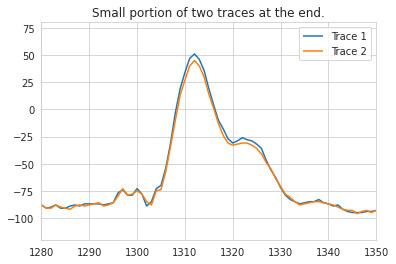

In [6]:
sns.lineplot(**TRACE_PLOT).set(xlim=(ASCAD.trace_len - 120, ASCAD.trace_len - 50),
                               title="Small portion of two traces at the end.")

### Mean of ASCAD traces.

In [7]:
print(f"Profiling trace mean: {ascad.default.profile.traces.mean():.2f},\n"
      f"Attack trace mean: {ascad.default.attack.traces.mean():.2f}")

Profiling trace mean: -63.59,
Attack trace mean: -63.67


### Variance of ASCAD traces.

In [8]:
print(f"Profiling trace variance: {ascad.default.profile.traces.var():.2f},\n"
      f"Attack trace variance: {ascad.default.attack.traces.var():.2f}")

Profiling trace variance: 1149.78,
Attack trace variance: 1138.65


### Mean and variance between all traces.

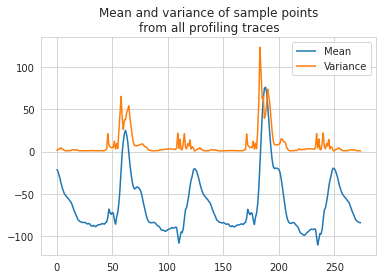

In [9]:
import matplotlib.pyplot as plt

DEFAULT_CUTOFF = 275

def plot_mv_traces(traces, cutoff=DEFAULT_CUTOFF):
    """
    Plots mean and variance (per sample point) of a given set of traces.
    """
    df_mv = pd.DataFrame(list(zip(traces.mean(axis=0), traces.var(axis=0)))[:cutoff], columns=["Mean", "Variance"])

    title = "Mean and variance of sample points\nfrom all profiling traces"
    sns.lineplot(dashes=[(1, 0), (1, 0)], data=df_mv).set_title(title)

def mv_diff(left, right):
    """
    Retrieves the difference in mean and variance (per sample point)
    between two sets of traces.
    """
    mean_diff = left.mean(axis=0) - right.mean(axis=0)
    var_diff = left.var(axis=0) - right.var(axis=0)

    return mean_diff, var_diff

def plot_mv_diff(left, right, title, cutoff=DEFAULT_CUTOFF):
    """
    Plots the difference in mean and variance (per sample point) between
    two sets of traces.
    """
    cols = ["Mean difference", "Variance difference"]
    df_mv_diff = pd.DataFrame(list(zip(*mv_diff(left, right)))[:cutoff], columns=cols)
    sns.lineplot(data=df_mv_diff[cols[0]])

    ax2 = plt.twinx()
    sns.lineplot(data=df_mv_diff[cols[1]], color=sns.color_palette()[1], ax=ax2).set_title(title)


plot_mv_traces(ascad.default.profile.traces)

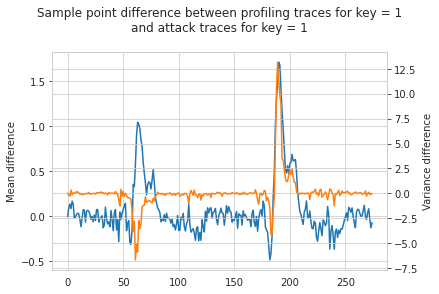

In [10]:
TITLE = "Sample point difference between profiling traces for key = 1\nand attack traces for key = 1\n"
plot_mv_diff(ascad.default.profile.filter_traces(1), ascad.default.attack.filter_traces(1), TITLE)


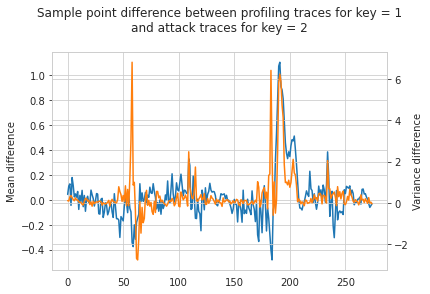

In [11]:
TITLE = "Sample point difference between profiling traces for key = 1\nand attack traces for key = 2\n"
plot_mv_diff(ascad.default.profile.filter_traces(1), ascad.default.attack.filter_traces(2), TITLE)

# Finding Points of Interest

In [12]:
from scipy import stats

### Statistical moment order difference

In [13]:
def statistical_moment(traces: np.array, moment=1):
    """
    Retrieves a statistical moment in a given order for a given set of traces.
    The moment
    """
    if moment == 1:
        return traces.mean(axis=0)
    if moment == 2:
        return traces.var(axis=0)
    if moment == 3:
        return stats.skew(traces, axis=0)
    if moment == 4:
        return stats.kurtosis(traces, axis=0)

    raise Exception("Moment not implemented.")

def calc_moment_difference(ts, moment=1):
    """
    Calculates the difference in statistical moment between power traces with
    equal keys and power traces with different keys.
    """
    kr = range(ASCAD.key_size)

    s_moment = lambda a: statistical_moment(a, moment)

    if isinstance(ts, TraceGroup):
        left = np.array([s_moment(ts.profile.filter_traces(k)) for k in kr])
        right = np.array([s_moment(ts.attack.filter_traces(k)) for k in kr])
    elif isinstance(ts, TraceCategory):
        left, right = [], []

        for k in kr:
            traces = ts.filter_traces(k)
            mid = round(len(traces) / 2)
            left.append(s_moment(traces[mid:]))
            right.append(s_moment(traces[:mid]))
    else:
        raise TypeError(f"Traces should be contained by TraceGroup or TraceCategory, not {type(ts)}.")

    dist_neq = [abs(left[i] - right[j]) for i in kr for j in kr if i != j]
    dist_eq = [abs(left[i] - right[i]) for i in kr]

    return np.mean(dist_neq, axis=0) - np.mean(dist_eq, axis=0)

def get_moment_differences(ts, trace_size=ASCAD.trace_len, max_moment=3):
    """
    Calculates the difference in statistical moment between power traces with
    equal keys and power traces with different keys, up to a given order of
    statistical moment.
    """
    mdiff = [calc_moment_difference(ts, i) for i in range(1, max_moment + 1)]

    return np.array([np.zeros(trace_size), *mdiff])

In [14]:
print(get_cache())

/home/berg/Documents/Afstudeer/LA/src/../.cache


In [15]:
M_DIFF_PATT = cache_np("mdiff_prof_att", get_moment_differences, ascad.default, v=1)
M_DIFF_PROF = cache_np("mdiff_prof", get_moment_differences, ascad.default.profile, v=1)
M_DIFF_MASK = cache_np("mdiff_mask", get_moment_differences, ascad.masked.profile, v=1)

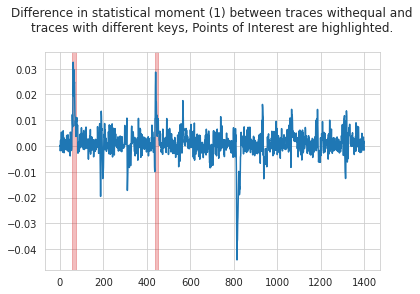

In [16]:
def plot_poi(mdiff, moment):
    """
    Plots moment difference with points of interest.
    """
    fig, ax = plt.subplots()

    title = f"Difference in statistical moment ({moment}) between traces with" \
            f"equal and\ntraces with different keys, Points of Interest are highlighted.\n"
    sns.lineplot(data=mdiff[moment]).set_title(title)

    for a, b in select_poi(mdiff[moment]):
        ax.axvspan(a, b, alpha=0.3, color=sns.color_palette()[3])

    plt.show()

def plot_poi_trace(trace, poi):
    """
    Plots power trace with points of interest.
    """
    fig, ax = plt.subplots()

    title = f"Some power trace, Points of Interest from\nstatistical moment (1) are highlighted.\n"
    sns.lineplot(data=trace, palette=[sns.color_palette()[4]]).set_title(title)

    for a, b in poi:
        ax.axvspan(a, b, alpha=0.3, color=sns.color_palette()[3])

    plt.show()

plot_poi(M_DIFF_PROF, 1)

#### Points of interest

In [17]:
select_poi(M_DIFF_PROF[1])

array([[ 54,  74],
       [436, 453]])

#### Points of interest with power trace

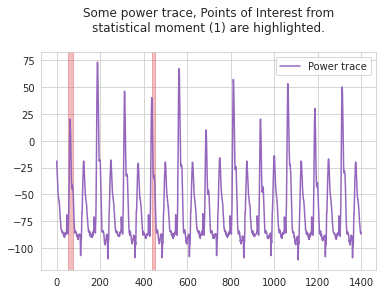

In [18]:
plot_poi_trace(pd.DataFrame(T1, columns=["Power trace"]), select_poi(M_DIFF_PROF[1]))

### PoI for the variance

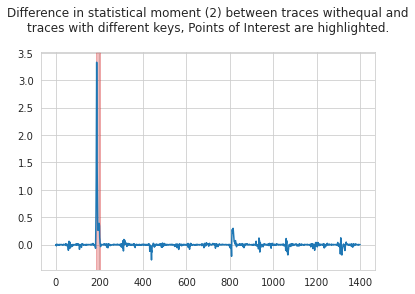

In [19]:
plot_poi(M_DIFF_PROF, 2)

### PoI for the skewness

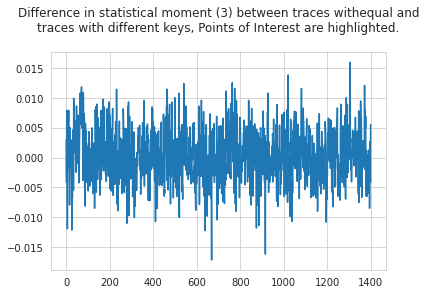

In [20]:
plot_poi(M_DIFF_PROF, 3)

### 1st key byte vs. 3rd key byte

Text(0.5, 1.0, 'Difference in statistical moment (1) for\nthe 1st key byte and the masked 3rd key byte')

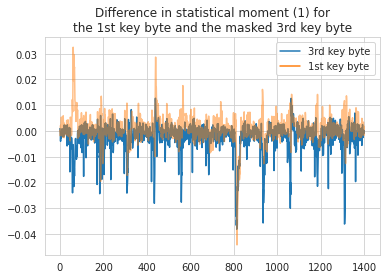

In [21]:
sns.lineplot(data=pd.DataFrame({"3rd key byte": M_DIFF_MASK[1]}))
sns.lineplot(data=pd.DataFrame({"1st key byte": M_DIFF_PROF[1]}), palette=[sns.color_palette()[1]], alpha=.5)\
    .set_title(f"Difference in statistical moment (1) for\nthe 1st key byte and the masked 3rd key byte")

### PoI for the mean - Masked key byte

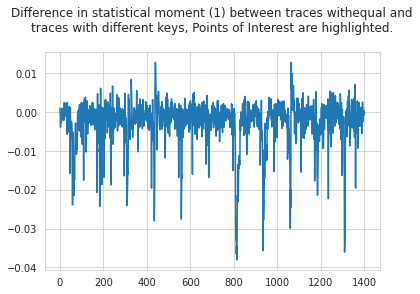

In [22]:
plot_poi(M_DIFF_MASK, 1)

### PoI for the variance - Masked key byte

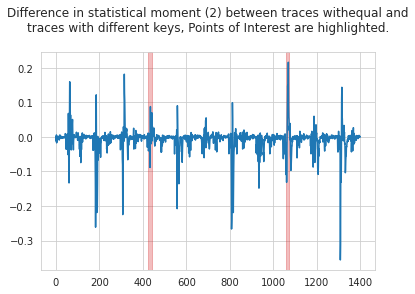

In [23]:
plot_poi(M_DIFF_MASK, 2)